# Importing libraries

In [1]:
# this module provides functions for interacting with the operating system 
import os
import pickle
import sys

# it's used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# Pandas used for data manipulation and analysis
import pandas as pd

# data visualization library for 2D and 3D plots, built on numpy
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn is based on matplotlib; used for plotting statistical graphics
import seaborn as sns

# plotting
import plotly.express as px

# sklearn helpful ML libraries including clasifiers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
import time

# to suppress warnings
import warnings
warnings.filterwarnings("ignore") 

# Importing Data and removing useless columns, splitting data exfiltration

In [2]:
train_path = "https://cloudstor.aarnet.edu.au/plus/s/umT99TnxvbpkkoE/download?path=%2FCSV%2FTraning%20and%20Testing%20Tets%20(5%25%20of%20the%20entier%20dataset)%2F10-best%20features%2F10-best%20Training-Testing%20split&files=UNSW_2018_IoT_Botnet_Final_10_best_Training.csv"
test_path = "https://cloudstor.aarnet.edu.au/plus/s/umT99TnxvbpkkoE/download?path=%2FCSV%2FTraning%20and%20Testing%20Tets%20(5%25%20of%20the%20entier%20dataset)%2F10-best%20features%2F10-best%20Training-Testing%20split&files=UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [3]:
#ARP packets were excluded because they are used to convert an IP address to a MAC address and irrelevant to the proposed attacks in the dataset
train_data = train_data[train_data.proto!="arp"]
test_data = test_data[test_data.proto!="arp"]

#dropping unused columns
train_data.drop(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport',"attack","category"],axis=1,inplace=True)
test_data.drop(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport',"attack","category"],axis=1,inplace=True)
full_data = pd.concat([train_data,test_data],axis=0)

In [4]:
data_exf = train_data.loc[train_data.subcategory=="Data_Exfiltration"].sample(n=2,random_state=42)
test_data=test_data.append([data_exf])
train_data=train_data.drop(data_exf.index)

In [5]:
# Place the class in the begining of the dataframe
class_train = train_data['subcategory']
train_data.drop(['subcategory'], axis=1, inplace=True)
train_data.insert(0, 'subcategory', class_train)

class_test = test_data['subcategory']
test_data.drop(['subcategory'], axis=1, inplace=True)
test_data.insert(0, 'subcategory', class_test)

class_full = full_data['subcategory']
full_data.drop(['subcategory'], axis=1, inplace=True)
full_data.insert(0, 'subcategory', class_full)

# Checking Balance of the Data

In [6]:
test_data.subcategory.value_counts()

UDP                  396568
TCP                  318332
Service_Scan          14530
OS_Fingerprint         3615
HTTP                    502
Normal                   98
Keylogging               13
Data_Exfiltration         2
Name: subcategory, dtype: int64

In [7]:
train_data.subcategory.value_counts()

UDP                  1584622
TCP                  1274811
Service_Scan           58592
OS_Fingerprint         14267
HTTP                    1965
Normal                   332
Keylogging                57
Data_Exfiltration          3
Name: subcategory, dtype: int64

In [8]:
d = full_data.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class distribution between attack subcategories on full data',labels = {'index':'Attack','y':'Volume'},color=d.values)
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Checking Missing Data and datatypes

In [9]:
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
missing_values = pd.DataFrame({'% missing': percent_missing})
missing_values.sort_values(by ='% missing' , ascending=False)

,% missing
subcategory,0.0
seq,0.0
stddev,0.0
N_IN_Conn_P_SrcIP,0.0
min,0.0
state_number,0.0
mean,0.0
N_IN_Conn_P_DstIP,0.0
drate,0.0
srate,0.0


In [10]:
pd.DataFrame({'Data Type': full_data.dtypes})

,Data Type
subcategory,object
seq,int64
stddev,float64
N_IN_Conn_P_SrcIP,int64
min,float64
state_number,int64
mean,float64
N_IN_Conn_P_DstIP,int64
drate,float64
srate,float64


In [11]:
# Grouping DDOS STUFF TOGETHER

In [12]:
full_data['subcategory'] = np.where((full_data['subcategory'] == 'TCP') | (full_data['subcategory'] == 'UDP') | (full_data['subcategory'] == 'HTTP') , 'DoS&DDoS', full_data['subcategory'])

# Undersampling

In [13]:
d = full_data.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT',labels = {'index':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

In [14]:
shuffled_df = full_data.sample(frac=1,random_state=4)

nondos_df = shuffled_df.loc[shuffled_df['subcategory'] != "DoS&DDoS"]

dos_df = shuffled_df.loc[shuffled_df['subcategory'] == "DoS&DDoS"].sample(n=73122,random_state=42)

normalized_full_df = pd.concat([nondos_df, dos_df])

#TRAIN after undersampling
d = normalized_full_df.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT (undersampled)',labels = {'index':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Splitting into Train and Test datasets

In [15]:
normalized_full_df.subcategory.value_counts()

Service_Scan         73122
DoS&DDoS             73122
OS_Fingerprint       17882
Normal                 430
Keylogging              70
Data_Exfiltration        5
Name: subcategory, dtype: int64

In [16]:
normalized_full_df.head()

,subcategory,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max
1285197,Service_Scan,20019,0.0,30,0.241459,6,0.241459,100,16.56596,20.707449,0.241459
700970,Service_Scan,19119,0.0,42,0.000000,5,0.000000,10,0.00000,0.000000,0.000000
506761,OS_Fingerprint,7147,0.0,44,0.003381,1,0.003381,100,0.00000,0.000000,0.003381
512201,Service_Scan,28496,0.0,100,0.004111,1,0.004111,100,0.00000,0.000000,0.004111
95683,OS_Fingerprint,5836,0.0,100,0.000807,1,0.000807,100,0.00000,0.000000,0.000807


In [17]:
X = normalized_full_df.drop(["subcategory"], axis = 1)
##dropping features
# X.drop(['state_number'],axis=1,inplace=True)

Y = normalized_full_df['subcategory']

X = pd.get_dummies(X, prefix_sep='_')
le = LabelEncoder()
Y2 = le.fit_transform(Y)
X2 = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X2, Y2, test_size = 0.2, random_state = 10)

In [18]:
print(X_Train.shape,X_Test.shape)

(131704, 10) (32927, 10)


In [19]:
print(Y_Train.shape,Y_Test.shape)

(131704,) (32927,)


In [20]:
print(Counter(Y_Test))
print(Counter(Y_Train))

Counter({5: 14713, 1: 14489, 4: 3634, 3: 77, 2: 12, 0: 2})
Counter({1: 58633, 5: 58409, 4: 14248, 3: 353, 2: 58, 0: 3})


In [21]:
d = pd.Series(data=Counter(Y_Train).values(), index = Counter(Y_Train).keys())
fig = px.bar(d, x=le.inverse_transform(d.index), y=d.values,title = 'Class Label Distribution in Bot-IoT - Training',labels = {'x':'Attack','y':'Volume'},color=d.values,text_auto='.3s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Oversampling

In [22]:
%%time

sm = SMOTE(random_state=42,sampling_strategy='auto',k_neighbors=2) #k_neighbors=3
X_Smote_Train, Y_Smote_Train = sm.fit_resample(X_Train, Y_Train)
oversampled_train = pd.concat([pd.DataFrame(Y_Smote_Train), pd.DataFrame(X_Smote_Train)], axis=1)
oversampled_train.columns = normalized_full_df.columns

CPU times: user 12.2 s, sys: 2.03 ms, total: 12.2 s
Wall time: 12.2 s


In [23]:
print(f"Before: {Counter(Y_Train)}, number of records: {sum(Counter(Y_Train).values())}")
print(f"After: {Counter(Y_Smote_Train)}, number of records: {sum(Counter(Y_Smote_Train).values())}")

Before: Counter({1: 58633, 5: 58409, 4: 14248, 3: 353, 2: 58, 0: 3}), number of records: 131704
After: Counter({5: 58633, 1: 58633, 4: 58633, 3: 58633, 2: 58633, 0: 58633}), number of records: 351798


In [24]:
d = oversampled_train.subcategory.value_counts()
fig = px.bar(d, x=le.inverse_transform(d.index), y=d.values,title = 'Class Label Distribution in Bot-IoT (oversampled with SMOTE)',labels = {'x':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Feature Correlation

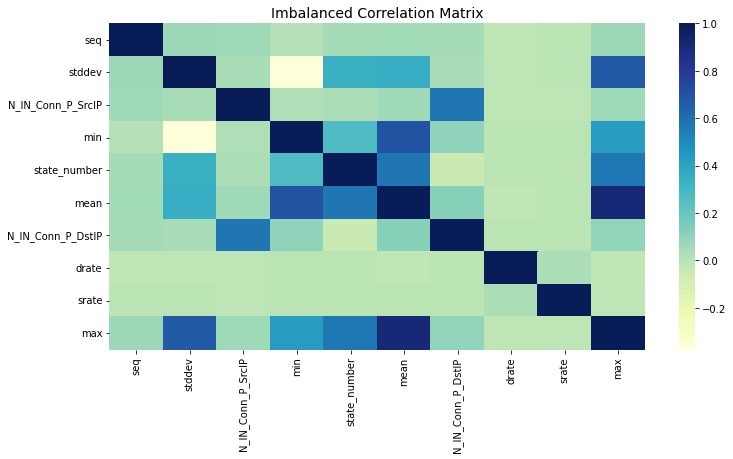

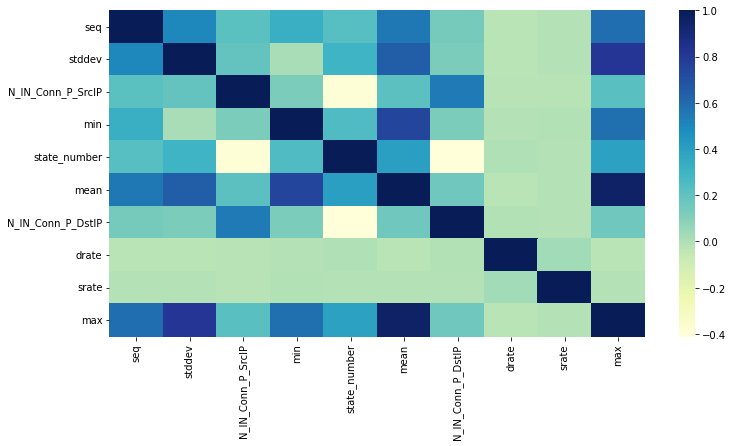

In [25]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(12,6))        
fig, ax1 = plt.subplots(figsize=(12,6))    

# Imbalanced DataFrame Correlation
corr = full_data.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

# Imbalanced DataFrame Correlation
corr2 = normalized_full_df.corr()
sns.heatmap(corr2, cmap='YlGnBu', annot_kws={'size':30}, ax=ax1)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

# Random Forests

In [26]:
%%time

rfc = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_Train,Y_Train) #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_forest = rfc.predict(X_Test)
print(classification_report(Y_Test,prediction_forest,target_names = le.inverse_transform(rfc.classes_),digits=3))
print(f"Accuracy: {rfc.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(rfc))} bytes")

cm_forest = confusion_matrix(Y_Test, prediction_forest)
print(cm_forest)

                   precision    recall  f1-score   support

Data_Exfiltration      1.000     1.000     1.000         2
         DoS&DDoS      1.000     1.000     1.000     14489
       Keylogging      0.923     1.000     0.960        12
           Normal      0.986     0.948     0.967        77
   OS_Fingerprint      0.921     0.914     0.917      3634
     Service_Scan      0.979     0.981     0.980     14713

         accuracy                          0.982     32927
        macro avg      0.968     0.974     0.971     32927
     weighted avg      0.982     0.982     0.982     32927

Accuracy: 0.9817171318370942
Model size: 5918486 bytes
[[    2     0     0     0     0     0]
 [    0 14489     0     0     0     0]
 [    0     0    12     0     0     0]
 [    0     1     0    73     1     2]
 [    0     1     1     0  3322   310]
 [    0     0     0     1   285 14427]]
CPU times: user 2.33 s, sys: 14.8 ms, total: 2.35 s
Wall time: 2.33 s


## Feature Importance using RF

In [27]:
feat_importances = pd.Series(rfc.feature_importances_, index= X.columns).sort_values(ascending=False)
fig = px.bar(d, x=feat_importances.index, y=feat_importances.values,title = 'Feature Importance using RF',labels = {'x':'Feature','y':'Importance'},color=feat_importances.values,text_auto=False)
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# K Nearest Neighbour

In [28]:
%%time

neigh = KNeighborsClassifier().fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_neigh = neigh.predict(X_Test)
print(classification_report(Y_Test,prediction_neigh,target_names = le.inverse_transform(neigh.classes_),digits=3))
print(f"Accuracy: {neigh.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(neigh))} bytes")

cm_knn = confusion_matrix(Y_Test, prediction_neigh)
print(cm_knn)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.998     0.995     0.996     14489
       Keylogging      0.857     1.000     0.923        12
           Normal      0.974     0.961     0.967        77
   OS_Fingerprint      0.937     0.936     0.937      3634
     Service_Scan      0.982     0.985     0.984     14713

         accuracy                          0.984     32927
        macro avg      0.791     0.813     0.801     32927
     weighted avg      0.984     0.984     0.984     32927

Accuracy: 0.9838430467397576
Model size: 14217748 bytes
[[    0     0     2     0     0     0]
 [    0 14414     0     1    29    45]
 [    0     0    12     0     0     0]
 [    0     0     0    74     0     3]
 [    0    15     0     0  3401   218]
 [    0    19     0     1   199 14494]]
CPU times: user 10.9 s, sys: 90.8 ms, total: 11 s
Wall time: 10.8 s


# Support Vector Machines (SVM)

In [29]:
%%time

svmclf = svm.SVC(random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
predictions_svm = svmclf.predict(X_Test)
print(classification_report(Y_Test,predictions_svm,target_names = le.inverse_transform(svmclf.classes_),digits=3))
print(f"Accuracy: {svmclf.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(svmclf))} bytes")

cm_svm = confusion_matrix(Y_Test, predictions_svm)
print(cm_svm)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.989     0.987     0.988     14489
       Keylogging      0.500     0.167     0.250        12
           Normal      0.775     0.896     0.831        77
   OS_Fingerprint      0.708     0.210     0.324      3634
     Service_Scan      0.829     0.974     0.896     14713

         accuracy                          0.895     32927
        macro avg      0.634     0.539     0.548     32927
     weighted avg      0.886     0.895     0.873     32927

Accuracy: 0.8949798038084247
Model size: 3883174 bytes
[[    0     0     2     0     0     0]
 [    0 14304     0     3    31   151]
 [    0     0     2     0     0    10]
 [    0     2     0    69     4     2]
 [    0    70     0     3   762  2799]
 [    0    88     0    14   279 14332]]
CPU times: user 8min 7s, sys: 1.24 s, total: 8min 9s
Wall time: 8min 8s


# Gradient Boosting

In [30]:
%%time

gb = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,max_depth=1, random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_gb = gb.predict(X_Test)
print(classification_report(Y_Test,prediction_gb,target_names = le.inverse_transform(gb.classes_),digits=3))
print(f"Accuracy: {gb.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(gb))} bytes")

cm_gbm = confusion_matrix(Y_Test, prediction_gb)
print(cm_gbm)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.992     0.998     0.995     14489
       Keylogging      0.000     0.000     0.000        12
           Normal      0.000     0.000     0.000        77
   OS_Fingerprint      0.827     0.273     0.411      3634
     Service_Scan      0.844     0.984     0.908     14713

         accuracy                          0.909     32927
        macro avg      0.444     0.376     0.386     32927
     weighted avg      0.905     0.909     0.889     32927

Accuracy: 0.9090108421660036
Model size: 34994 bytes
[[    0     0     0     0     0     2]
 [    0 14465     0     0     0    24]
 [    0     0     0     0     0    12]
 [    0    12     0     0     1    64]
 [    0    66     0     0   993  2575]
 [    0    33     0     0   207 14473]]
CPU times: user 9.15 s, sys: 48.9 ms, total: 9.2 s
Wall time: 9.19 s


# Adaboost

In [31]:
%%time

adab = AdaBoostClassifier(n_estimators=10, random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_adab = adab.predict(X_Test)
print(classification_report(Y_Test,prediction_adab,target_names = le.inverse_transform(adab.classes_),digits=3))
print(f"Accuracy: {adab.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(adab))} bytes")

cm_ada = confusion_matrix(Y_Test, prediction_adab)
print(cm_ada)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.370     0.223     0.278     14489
       Keylogging      0.857     1.000     0.923        12
           Normal      0.311     0.597     0.409        77
   OS_Fingerprint      0.118     0.713     0.202      3634
     Service_Scan      0.893     0.126     0.220     14713

         accuracy                          0.235     32927
        macro avg      0.425     0.443     0.339     32927
     weighted avg      0.576     0.235     0.244     32927

Accuracy: 0.23467063504115163
Model size: 8777 bytes
[[    0     0     2     0     0     0]
 [    0  3230     0    11 11074   174]
 [    0     0    12     0     0     0]
 [    0     0     0    46     0    31]
 [    0  1021     0     7  2590    16]
 [    0  4486     0    84  8294  1849]]
CPU times: user 2.01 s, sys: 10.1 ms, total: 2.02 s
Wall time: 2.02 s


# Artifical Neural Networks

In [32]:
%%time

ANN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,2), random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_ann = ANN.predict(X_Test)
print(classification_report(Y_Test,prediction_ann,target_names = le.inverse_transform(ANN.classes_),digits=3))
print(f"Accuracy: {ANN.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(ANN))} bytes")

cm_ann = confusion_matrix(Y_Test, prediction_ann)
print(cm_ann)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.994     0.985     0.990     14489
       Keylogging      0.000     0.000     0.000        12
           Normal      0.593     0.208     0.308        77
   OS_Fingerprint      0.000     0.000     0.000      3634
     Service_Scan      0.791     0.997     0.882     14713

         accuracy                          0.879     32927
        macro avg      0.396     0.365     0.363     32927
     weighted avg      0.792     0.879     0.830     32927

Accuracy: 0.879399884593191
Model size: 5704 bytes
[[    0     0     0     0     0     2]
 [    0 14268     0     6     0   215]
 [    0     0     0     0     0    12]
 [    0    34     0    16     0    27]
 [    0    10     0     0     0  3624]
 [    0    36     0     5     0 14672]]
CPU times: user 43.4 s, sys: 25.3 s, total: 1min 8s
Wall time: 35.7 s


In [33]:
%%time

import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
ann_clf = Sequential()

# Adding the input layer and the first hidden layer
ann_clf.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
# classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
ann_clf.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
ann_clf.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#summary
ann_clf.summary()

# Fitting the ANN to the Training set
ann_clf.fit(X_Train,Y_Train , epochs = 10) #SMOTE: X_Smote_Train,Y_Smote_Train

# Predicting the Test set results
predict_x=ann_clf.predict(X_Test) 
classes_x=np.argmax(predict_x,axis=1)

print(classification_report(Y_Test, classes_x,digits=3))
print(f"Model size: {sys.getsizeof(pickle.dumps(ann_clf))} bytes")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4116/4116 [==============================] - 10s 2ms/step - loss: 0.4065 - accuracy: 0.8545
Epoch 2/10
4116/4116 [==============================] - 7s 2ms/step - loss: 0.3053 - accuracy: 0.8696
Epoch 3/10
4116/4116 [==============================] - 6s 2ms/step - loss: 0.2941 - accuracy: 0.8707
Epoch 4/10
4116/4116 [==============================] - 6s 2ms/step - loss: 0.2861 - accuracy: 0.8712
Epoch 5/10
4116/4116 [=======================